<div class="alert alert-info">
Ссылка для просмотра ноутбука в интерактивном режиме для использования гиперссылок и корректного отображения разметки:<br>
<a href='https://nbviewer.org/github/yulianikola/portfolio/blob/master/data_analysis_python/5_correl_linear_regression/water.ipynb'>water</a></div>

### Корреляция, линейная регрессия

#### Данные Mortality and Water Hardness

В этом датасете содержатся данные по средней годовой смертности на
100000 населения и концентрации кальция в питьевой воде для 61
большого города в Англии и Уэльсе. Города дополнительно поделены на
северные и южные.<br>
https://www.kaggle.com/ukveteran/mortality-and-water-hardness

#### Задачи:
1. Есть ли связь между жёсткостью воды и средней годовой смертностью?
    - Построить точечный график
    - Рассчитать коэффициенты корреляции Пирсона и Спирмена
    - Построить модель линейной регрессии
    - Рассчитать коэффициент детерминации
    - Вывести график остатков
1. Сохраняется ли аналогичная зависимость для северных и южных городов по отдельности?
    - Разделить данные на 2 группы
    - Повторить аналогичные шаги из пункта 1 для каждой группы по отдельности

<p id="0">
<h4>Содержание</h4>
<ul type="square"><a href="#1"><li>Знакомство с данными</li></a>
<a href="#2"><li>Полный датасет</li></a>
    <ul>
    <a href="#2.1"><li>Корреляция</li></a>
    <a href="#2.2"><li>Регрессия 1 (train/test 80/20)</li></a>
    <a href="#2.3"><li>Кросс-валидация 1</li></a> 
    <a href="#2.4"><li>Регрессия 2 (train/test 70/30)</li></a>
    <a href="#2.5"><li>Вывод</li></a>
    </ul>
<a href="#3"><li>Две подгруппы: юг и север</li></a>
    <ul>
    <a href="#3.1"><li>Корреляция</li></a>
    <a href="#3.2"><li>Регрессия</li></a>
    <a href="#3.3"><li>Кросс-валидация</li></a>
    <a href="#3.4"><li>Вывод</li></a>
    </ul>
<a href="#4"><li>Двухфакторная регрессия</li></a>
    <ul>
    <a href="#4.1"><li>Регрессия</li></a>
    <a href="#4.2"><li>Кросс-валидация</li></a>
    <a href="#4.3"><li>Вывод</li></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import statsmodels.api
import warnings
warnings.filterwarnings('ignore')

<p id="1">
<h4>Знакомство с данными</h4>

Загружаем данные, используем нулевой столбец как индексный:

In [2]:
water = pd.read_csv('C:\\python\\portfolio\\data_analysis_python\\5_correl_linear_regression\\data\\water.csv',
                    index_col = 0)

В данных четыре столбца: север/юг, название города и числовые смертность и жесткость воды:

In [3]:
water.head()

,location,town,mortality,hardness
1,South,Bath,1247,105
2,North,Birkenhead,1668,17
3,South,Birmingham,1466,5
4,North,Blackburn,1800,14
5,North,Blackpool,1609,18


Всего 61 строка в данных. Пропусков нет, числовые столбцы определились как числовой тип данных, значит нет и "пропусков", выраженных другими символами:

In [4]:
water.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 1 to 61
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   location   61 non-null     object
 1   town       61 non-null     object
 2   mortality  61 non-null     int64 
 3   hardness   61 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.4+ KB


Статистики числовых показателей. Большой разброс по жесткости от 5 до 138, при этом не более чем в 75% городов жесткость меньше 75.

In [5]:
water.describe()

,mortality,hardness
count,61.000000,61.000000
mean,1524.147541,47.180328
std,187.668754,38.093966
min,1096.000000,5.000000
25%,1379.000000,14.000000
50%,1555.000000,39.000000
75%,1668.000000,75.000000
max,1987.000000,138.000000


По боксплотам и гистограммам можно сказать, что у смертности более менее симметричное распределение. У жесткости асимметричное и скошено вправо. По боксплотам выбросов нет.

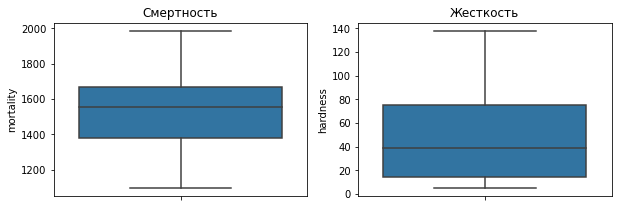

In [6]:
plt.figure(figsize = (10, 7)) 
plt.subplot(2, 2, 1)
sns.boxplot(y = water.mortality);
plt.title('Смертность');
plt.subplot(2, 2, 2)
sns.boxplot(y = water.hardness);
plt.title('Жесткость');

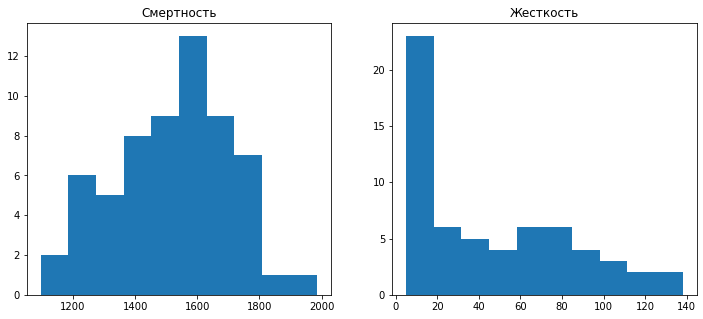

In [7]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1, 2, 1)
plt.hist(water.mortality);
plt.title('Смертность');
plt.subplot(1, 2, 2)
plt.hist(water.hardness);
plt.title('Жесткость');

<a href="#0"><h4>Наверх</h4></a>

<p id="2">
<p id="2.1">
<h3>Часть 1 (полный датасет)</h3>
<h4>Корреляция</h4>

Построим точечный график смертности и жесткости воды. Оба показателя непрерывного количественного типа. Наблюдается средняя линейная обратная связь: с увеличением жесткости воды смертность имеет тенденцию к снижению. Значительных выбросов не видно, но бросается в глаза точка со смертностью около 2000.

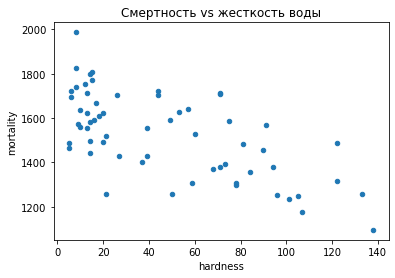

In [8]:
water.plot(kind = 'scatter', x = 'hardness', y = 'mortality', title = 'Смертность vs жесткость воды');

Линейный коэффициент корреляции Пирсона: обратная связь, средней силы - при увеличении жесткости воды смертность имеет тенденцию к уменьшению. Исключение выброса со смертностью около 2000 на коэффициент почти не повлияло.

In [9]:
print('коэф Пирсона', water[['mortality', 'hardness']].corr().loc['mortality','hardness'])
print('коэф Пирсона, без выброса', water[water.mortality < 1900][['mortality', 'hardness']].corr().loc['mortality','hardness'])

коэф Пирсона -0.6548486232042469
коэф Пирсона, без выброса -0.6519355265052948


У нас два непрерывных количественных признака и это случай использования коэффициента Пирсона. Но некоторые рекомендуют использовать Спирмена в случае с отклонением от нормальности. Хотя есть мнение, что доказательства того, что Спирмен справится лучше, неочевидны. Также есть мнение, что значительное различие Пирсона и Спирмена может указывать на наличие значительных выбросов. Ранговый коэффициент корреляции Спирмена получился немного ниже Пирсона, что на мой взгляд скорее всего означает отсутствие серьезных проблем с выбросами и асимметричностью.

In [10]:
water[['mortality', 'hardness']].corr(method = 'spearman').loc['mortality','hardness']

-0.6316646189166502

<a href="#0"><h4>Наверх</h4></a>

<p id="2.2">
<h4>Регрессия 1</h4>

Определяем зависимую и независимую переменные, будем прогнозировать смертность на основе жесткости воды:

In [11]:
X = water[['hardness']]
y = water['mortality']

Поделим данные случайным образом на обучающую и тестовую выборку, с общепринятыми 30% на тест:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

Обучим модель линейной регрессии на обучающей выборке:

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

* Модель однофакторной линейной регресии.
* Угловой коэффициент отрицательный, что согласуется с обратной корреляцией между переменными.
* При сравнении двух городов, в городе с жесткостью воды на единицу выше, ожидается (в среднем) смертность на 3,1 (на 100тыс) ниже.
* При нулевой жесткости смертность ожидается на уровне 1668 (константа). Не знаю, возможна ли в приципе нулевая жесткость воды, но в наших данных минимум это 5. Грубо говоря, получается это такая максимальная смертность по модели, так как при возрастании Х от 0 выше, прогнозная смертность будет понижаться.

In [14]:
print(f'y = {model.coef_[0]:.2f} X + {model.intercept_:.2f}')

y = -3.13 X + 1668.97


Коэффициент детерминации: наша модель объясняет зависимость между смертностью и жесткостью воды лучше чем наивная модель, но на средне-слабом уровне, 50 % дисперсии смертности объясняется жесткостью воды, нашей регрессионной моделью.

In [15]:
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.5046490611017092

Посмотрим на взаимосвязь между переменными в обучающей и тестовой выборках. При такой разбивке в обеих выборках прослеживается обратная линейная средняя связь.

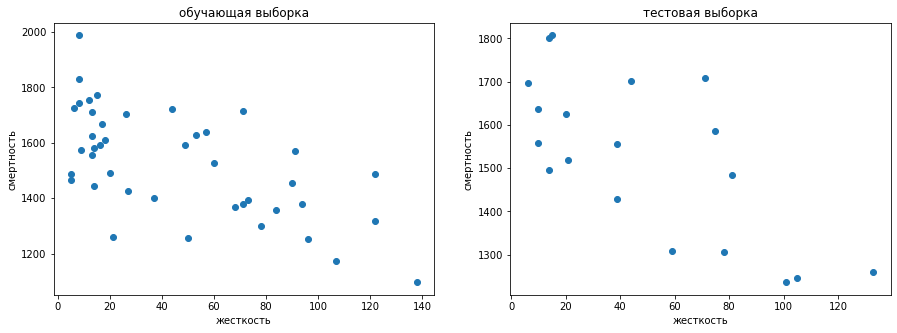

In [16]:
plt.figure(figsize = (15, 5)) 
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train);
plt.title('обучающая выборка');
plt.xlabel('жесткость');
plt.ylabel('смертность');
plt.subplot(1, 2, 2)
plt.scatter(X_test, y_test);
plt.title('тестовая выборка');
plt.xlabel('жесткость');
plt.ylabel('смертность');

Проверим выполнение условий регрессионной процедуры.

Посмотрим распределение остатков. Ошибка прогноза, остаток - необъясненная вариация смертности. Гистограмма разве что отдаленно напоминает нормальное распределение.

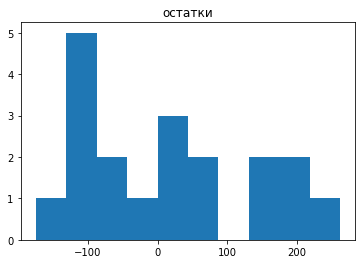

In [17]:
plt.hist(y_test - y_pred);
plt.title('остатки');

Построим QQ plot - точки в целом двигаются вдоль прямой. Будем считать, что серьезного отклонения остатков от нормального распределения нет.

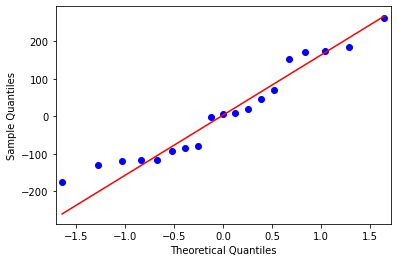

In [18]:
statsmodels.graphics.gofplots.qqplot(y_test - y_pred, line = 'q');

Посмотрим на взаимосвязь прогнозных значений и остатков. У нас не временные ряды, но тем не менее какой-то зависимости не наблюдается. Остатки выглядят достаточно хаотичными, в чередованиии знаков закономерности не наблюдается (независимость остатков). Вариация остатков в целом одинакова вдоль оси х, тенденции не наблюдается (гомоскедастичность). Точки достаточно рассеяны/удалены относительно нуля - невысокая точность прогноза.

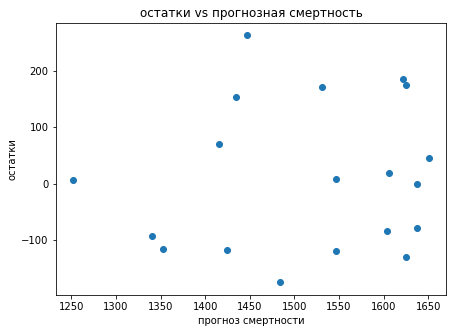

In [19]:
plt.figure(figsize = (7, 5)) 
plt.scatter(y_pred, y_test - y_pred);
plt.title('остатки vs прогнозная смертность');
plt.xlabel('прогноз смертности');
plt.ylabel('остатки');

Построение графика остатков против независимой переменной может помочь обнаружить упущенную нелинейность модели. В данном случае остатки достаточно хаотично распределены, нелинейной зависимости не наблюдается.

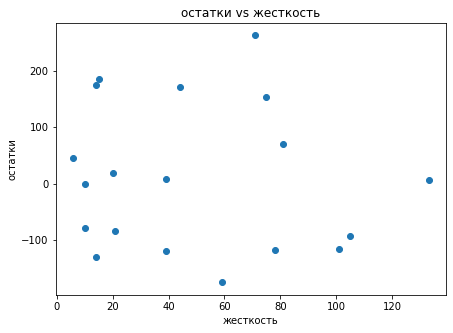

In [20]:
plt.figure(figsize = (7, 5)) 
plt.scatter(X_test, y_test - y_pred);
plt.title('остатки vs жесткость');
plt.xlabel('жесткость');
plt.ylabel('остатки');

Посмотрим еще раз на взаимосвязь жесткости и смертности на тестовой выборке. Нанесем на график линию регресии, т.е. прогнозные значения, и выделим остатки. Снова видим, что многие точки прогноза значительно удалены от фактических:

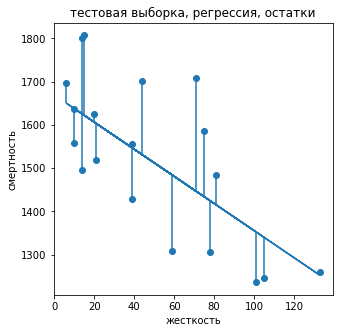

In [21]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
ax.plot(X_test, y_pred);
ax.scatter(X_test, y_test);
ax.vlines(X_test, y_pred, y_test);
ax.set(xlabel = 'hardness', ylabel = 'mortality')
plt.title('тестовая выборка, регрессия, остатки');
plt.xlabel('жесткость');
plt.ylabel('смертность');

In [22]:
import numpy as np

<a href="#0"><h4>Наверх</h4></a>

<p id="2.3">
<h4>Кросс-валидация 1</h4>

Датасет очень маленький, в таких случаях разделение выборки на обучающую и тестовую может иметь значительное влияние на результат. Проверим устойчивость наших результатов с помощью "ручной" кросс-валидации.

* Построим модель на 1000 случайных обучающих выборок. Посчитаем коэффициенты регрессии: средние, медианные, min, max.
* Оценим модель на 1000 случайных тестовых выборках. Посчитаем коэффициент детерминации: средний, медианный, min, max.
* Получившийся выше коэффициент детерминации 0.5 скорее всего случайным образом завышен, тк на 1000 выборок средний 0.34, медианный 0.38.
* Коэффициенты регрессии отличаются незначительно.
* Так как данных мало, а в тестовой выборе их оказывается совсем немного, то разбивка на выборки вероятно оказывает влияние на расчет коэффициента детерминации.

In [23]:
reg_dict = {'a':[],'b':[],'R':[]}
for i in range(1000):
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size = 0.30)
    model_ = LinearRegression()
    model_.fit(X_train_, y_train_)
    reg_dict['a'].append(model_.coef_[0])
    reg_dict['b'].append(model_.intercept_)
    y_pred_ = model_.predict(X_test_)
    reg_dict['R'].append(model_.score(X_test_, y_test_))

print('угловой коэффициент')
print(np.mean(np.array(reg_dict['a'])), 
        np.median(np.array(reg_dict['a'])), 
        np.min(np.array(reg_dict['a'])), 
        np.max(np.array(reg_dict['a'])))
print('свободный коэффициент')
print(np.mean(np.array(reg_dict['b'])), 
      np.median(np.array(reg_dict['b'])),
      np.min(np.array(reg_dict['b'])), 
      np.max(np.array(reg_dict['b'])))
print('коэф. детерминации')
print(np.mean(np.array(reg_dict['R'])),
      np.median(np.array(reg_dict['R'])),
      np.min(np.array(reg_dict['R'])),
      np.max(np.array(reg_dict['R'])))

угловой коэффициент
-3.224223735811647 -3.2208267281682534 -4.209923889250558 -2.128715869197192
свободный коэффициент
1676.6393305716895 1676.610741148414 1616.5961179749117 1743.2960189145974
коэф. детерминации
0.3332891222287791 0.3789493776522817 -0.6520265100023732 0.6605159109816967


<a href="#0"><h4>Наверх</h4></a>

<p id="2.4">
<h4>Регрессия 2</h4>

Объем данных маленький, всего 61 строка. Попробуем оставить больше долю на учебную выборку, так как важнее, чтобы модель лучше обучилась. Указываем то же зерно случайности как выше. Все коэффициенты изменились незначительно по сравнению с разбивкой 30/70.

In [24]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size = 0.20, random_state = 42)
model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)
print(f'y = {model_2.coef_[0]:.2f} X + {model_2.intercept_:.2f}')
y_pred_2 = model_2.predict(X_test_2)
print(model_2.score(X_test_2, y_test_2))

y = -3.28 X + 1683.92
0.5099679408034544


Поведение остатков по сути не отличается:

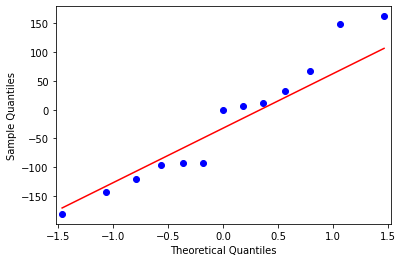

In [25]:
statsmodels.graphics.gofplots.qqplot(y_test_2 - y_pred_2, line = 'q');

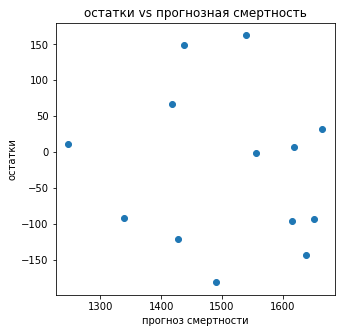

In [26]:
plt.figure(figsize = (5, 5)) 
plt.scatter(y_pred_2, y_test_2 - y_pred_2);
plt.title('остатки vs прогнозная смертность');
plt.xlabel('прогноз смертности');
plt.ylabel('остатки');

Проведем кросс-валидацию.<br>
* Коэффициенты регрессии отличаются незначительно от 1000 выборок с разбивкой 30/70 и от случайной разбивки 20/80.
* По коэффициенту детерминации разброс больше чем на выборках 30/70: средний 0.29, медианный 0.36. Коэффициент, полученный на случайной выборке 20/80 так же выглядит завышенным.

In [27]:
reg_dict_2 = {'a':[],'b':[],'R':[]}
for i in range(1000):
    X_train_2_, X_test_2_, y_train_2_, y_test_2_ = train_test_split(X, y, test_size=0.20)
    model_2_ = LinearRegression()
    model_2_.fit(X_train_2_, y_train_2_)
    reg_dict_2['a'].append(model_2_.coef_[0])
    reg_dict_2['b'].append(model_2_.intercept_)
    y_pred_2_ = model_2_.predict(X_test_2_)
    reg_dict_2['R'].append(model_2_.score(X_test_2_, y_test_2_))

print('угловой коэффициент')
print(np.mean(np.array(reg_dict_2['a'])),
     np.median(np.array(reg_dict_2['a'])),
     np.min(np.array(reg_dict_2['a'])),
     np.max(np.array(reg_dict_2['a'])))
print('свободный коэффициент')
print(np.mean(np.array(reg_dict_2['b'])),
     np.median(np.array(reg_dict_2['b'])),
      np.min(np.array(reg_dict_2['b'])),
      np.max(np.array(reg_dict_2['b'])))
print('коэф. детерминации')
print(np.mean(np.array(reg_dict_2['R'])),
     np.median(np.array(reg_dict_2['R'])),
     np.min(np.array(reg_dict_2['R'])),
     np.max(np.array(reg_dict_2['R'])))

угловой коэффициент
-3.228217472752208 -3.2319819397045064 -3.8936239368713768 -2.3691349897268017
свободный коэффициент
1676.6099007739956 1676.885980561556 1625.04648983287 1724.107845993206
коэф. детерминации
0.30807857930264426 0.3549922353778145 -1.004040071854578 0.7775539049513844


<a href="#0"><h4>Наверх</h4></a>

<p id="2.5">
<h4>Вывод</h4><br>
* По одной случайной разбивке на обучающую и тестовую выборки (20 и 30%) получается модель, по которой 50 % дисперсии смертности объясняется жесткостью воды.<br>
* Но если построить и оценить модель на 1000 случайных разбивок, получается что в среднем коэффициенты этих моделей незначительно отличаются,  а вот коэф. детерминации средний 0.3, медианный 0.37.<br>
* При этом разброс его значений в выборках 30/70 от -0.6 до 0.6, а в выборках 20/80 еще больше: от -2.5 до 0.7.<br>
* Я бы сказала, что средняя корреляция между смертностью и жесткостью есть. Но опираться на прогноз смертности на основе жесткости воды не стоит - качество такой модели судя по всему достаточно низкое.<br>
* Возможно есть какой-то "третий" признак, который связывает смертность и жесткость.

<p id="3">
<h3>Часть 2 (юг и север)</h3>


Разделим данные на две группы: южные и северные города.

In [28]:
water_south = water[water.location == 'South']
water_north = water[water.location == 'North']

* Показатели смертности на севере выше чем на юге: и по среднему, по всем квартилям, по min и max.
* Показатели жесткости воды на севере ниже чем на юге: по среднему и по всем квантилям.
* Может быть есть какой-то "третий" фактор, связанные с повышенной смертностью на севере?

In [29]:
water_south.describe()

,mortality,hardness
count,26.000000,26.000000
mean,1376.807692,69.769231
std,140.269175,40.360682
min,1096.000000,5.000000
25%,1259.250000,40.250000
50%,1364.000000,75.500000
75%,1485.750000,99.750000
max,1627.000000,138.000000


In [30]:
water_north.describe()

,mortality,hardness
count,35.000000,35.000000
mean,1633.600000,30.400000
std,136.936911,26.134494
min,1378.000000,6.000000
25%,1557.500000,12.500000
50%,1637.000000,17.000000
75%,1718.000000,44.000000
max,1987.000000,94.000000


Распределение жесткости на севере значительно асимметричное (скошено вправо) по сравнению с югом:

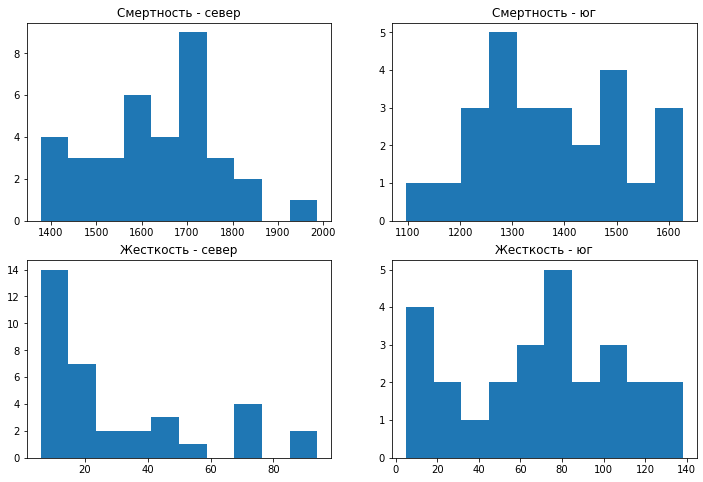

In [31]:
plt.figure(figsize = (12, 8)) 
plt.subplot(2, 2, 1)
plt.hist(water_north.mortality);
plt.title('Смертность - север');
plt.subplot(2, 2, 2)
plt.hist(water_south.mortality);
plt.title('Смертность - юг');
plt.subplot(2, 2, 3)
plt.hist(water_north.hardness);
plt.title('Жесткость - север');
plt.subplot(2, 2, 4)
plt.hist(water_south.hardness);
plt.title('Жесткость - юг');

<p id="3.1">
<h4>Корреляция</h4>


* Наблюдается средняя линейная обратная связь по южным городам. При увеличении жесткости воды смертность имеет тенденцию к снижению.
* Но по северным городам график более хаотичный, связь слабая или может быть нелинейная (немного напоминает гиперболу)?
* На севере снова бросается в глаза точка со смертностью около 2000.
* На севере связь лучше прослеживается в зоне низкой жесткости воды.

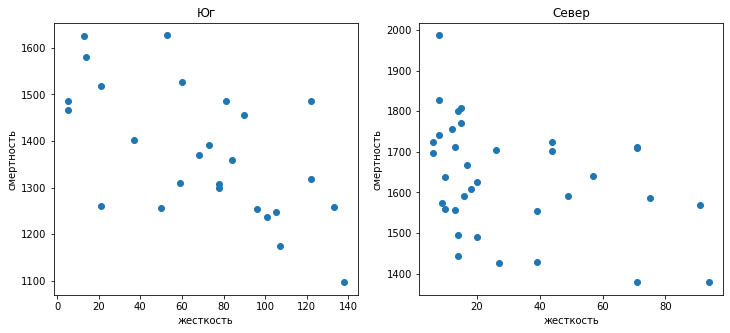

In [32]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1, 2, 1)
plt.scatter(water_south.hardness, water_south.mortality);
plt.title('Юг');
plt.xlabel('жесткость');
plt.ylabel('смертность');
plt.subplot(1, 2, 2)
plt.scatter(water_north.hardness, water_north.mortality);
plt.title('Север');
plt.xlabel('жесткость');
plt.ylabel('смертность');

Коэффициент Пирсона по южным городам похож на коэффициент по общей выборке - средняя обратная связь. А коэффициент по северным значительно меньше - слабая обратная линейная связь. Исключение выброса со смертностью около 2000 на коэффициент севера почти не повлияло:

In [33]:
print('юг', water_south[['mortality', 'hardness']].corr().loc['mortality','hardness'])
print('север', water_north[['mortality', 'hardness']].corr().loc['mortality','hardness'])
print('север, без выброса', water_north[water.mortality < 1900][['mortality', 'hardness']].corr().loc['mortality','hardness'])

юг -0.6021532715484159
север -0.3685978383288716
север, без выброса -0.3413952194063407


Коэффициент Спирмена по обеим группам близок Пирсону:

In [34]:
print('юг', water_south[['mortality', 'hardness']].corr(method='spearman').loc['mortality','hardness'])
print('север', water_north[['mortality', 'hardness']].corr(method='spearman').loc['mortality','hardness'])

юг -0.5957229185013566
север -0.4042078956511175


<a href="#0"><h4>Наверх</h4></a>

<p id="3.2">
<h4>Регрессия</h4>

Построим регрессии для юга и севера отдельно:

In [35]:
X_s = water_south[['hardness']]
y_s = water_south['mortality']
X_n = water_north[['hardness']]
y_n = water_north['mortality']

Так как и без того небольшой объем данных делится на две группы,  а увеличение обучающей выборки с 70 до 80% не дало явного преимущества, то оставим долю обучающей выборки на 70%. Оставляем то же зерно случайности как выше.

In [36]:
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size = 0.30, random_state = 42)
X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(X_n, y_n, test_size = 0.30, random_state = 42)

In [37]:
model_s = LinearRegression()
model_s.fit(X_s_train, y_s_train)
model_n = LinearRegression()
model_n.fit(X_n_train, y_n_train)

LinearRegression()

* В обеих группах угловой коэффициент отрицательный, что согласуется с обратной корреляцией между переменными.
* При сравнении двух южных городов, в городе с жесткостью воды на единицу выше, ожидается (в среднем) смертность на 3,5 (на 100тыс) ниже. Значение схоже с коэффициентом по общей выборке.
* При нулевой жесткости смертность ожидается на уровне 1640 (константа).
<br><br>
* При сравнении двух северных городов, в городе с жесткостью воды на единицу выше, ожидается (в среднем) смертность на 2 (на 100тыс) ниже. Значение меньше по модулю чем в общей выборке и в группе южных городов.
* При нулевой жесткости смертность ожидается на уровне 1688.

In [38]:
print('юг', model_s.coef_[0], model_s.intercept_)
print('север', model_n.coef_[0], model_n.intercept_)

юг -3.513429212378231 1640.2204603423374
север -1.9768622600638235 1688.150229031281


* По южным городам получается неадекватное значение коэффициента детерминации - модель работает хуже наивной?
* По северным городам коэффициент по сути равен 0. 
* Вариация смертности не объясняется жесткостью воды, если разделить города на северные и южные.

In [39]:
y_s_pred = model_s.predict(X_s_test)
print('юг', model_s.score(X_s_test, y_s_test))
y_n_pred = model_n.predict(X_n_test)
print('север', model_n.score(X_n_test, y_n_test))

юг -2.5519223012352077
север 0.018885304285745863


На обучающей выборке южных городов прослеживается обратная средняя связь. А на тестовой - мало точек и достаточно хаотичны,
что видимо и привело к неадекватному коэф. детерминации.

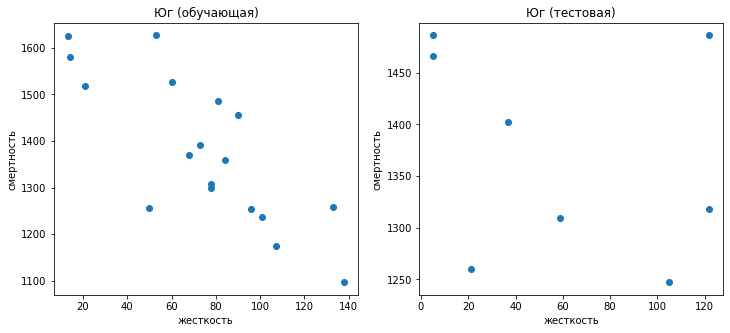

In [40]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1, 2, 1)
plt.scatter(X_s_train, y_s_train);
plt.title('Юг (обучающая)');
plt.xlabel('жесткость');
plt.ylabel('смертность');
plt.subplot(1, 2, 2)
plt.scatter(X_s_test, y_s_test);
plt.title('Юг (тестовая)');
plt.xlabel('жесткость');
plt.ylabel('смертность');

На обучающей выборке северных городов обратная средняя связь тоже прослеживается в зоне низкой жесткости. А на тестовой- мало точек и достаточно хаотичны, что видимо и привело к неадекватному коэф. детерминации. Хотя в зоне низкой жесткости можно увидеть некоторую обратную связь.

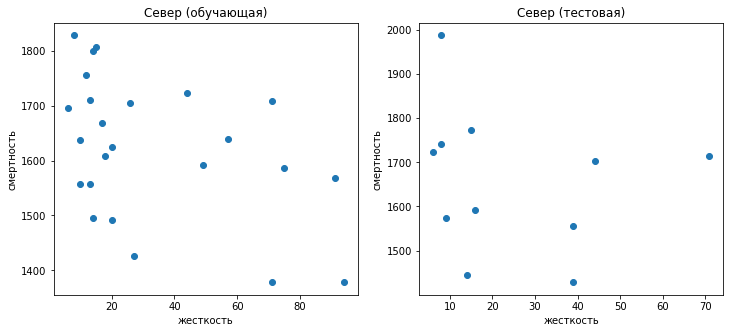

In [41]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1, 2, 1)
plt.scatter(X_n_train, y_n_train);
plt.title('Север (обучающая)');
plt.xlabel('жесткость');
plt.ylabel('смертность');
plt.subplot(1, 2, 2)
plt.scatter(X_n_test, y_n_test);
plt.title('Север (тестовая)');
plt.xlabel('жесткость');
plt.ylabel('смертность');

Посмотрим распределение остатков. Очень мало точек, но гистограмма юга отдаленно напоминает нормальное распределение, а север - меньше.

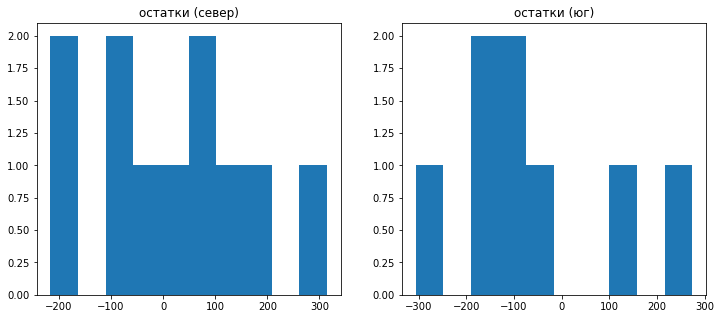

In [42]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1, 2, 1)
plt.hist(y_n_test - y_n_pred);
plt.title('остатки (север)');
plt.subplot(1, 2, 2)
plt.hist(y_s_test - y_s_pred);
plt.title('остатки (юг)');

На QQ plot севера точки в целом двигаются вдоль прямой, на юге - более значительные отклонения по краям. Но в целом серьезного отклонения от нормального распределения, тем более для такого числа точек, нет.

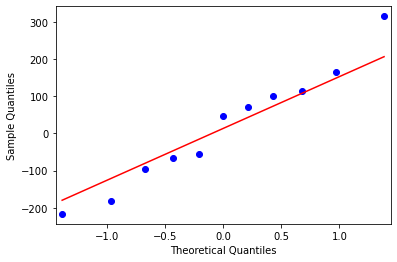

In [43]:
statsmodels.graphics.gofplots.qqplot(y_n_test - y_n_pred, line = 'q');

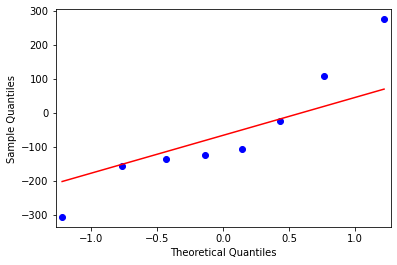

In [44]:
statsmodels.graphics.gofplots.qqplot(y_s_test - y_s_pred, line = 'q');

* На юге остатки выстраиваются в некоторую систему, при меньших значениях прогноза - положительные ошибки, при более высоких - отрицательные. Точки достаточно рассеяны/удалены относительно нуля - невысокая точность прогноза.
* На севере в чередовании знаков закономерности не наблюдается. Остатки выглядят достаточно хаотично. Точность тоже невысокая.

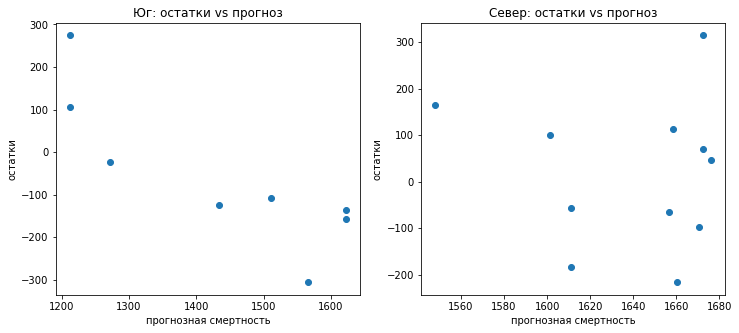

In [45]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1, 2, 1)
plt.scatter(y_s_pred, y_s_test - y_s_pred);
plt.title('Юг: остатки vs прогноз');
plt.xlabel('прогнозная смертность');
plt.ylabel('остатки');
plt.subplot(1, 2, 2)
plt.scatter(y_n_pred, y_n_test - y_n_pred);
plt.title('Север: остатки vs прогноз');
plt.xlabel('прогнозная смертность');
plt.ylabel('остатки');

Снова видим, что многие точки прогноза значительно удалены от фактических:

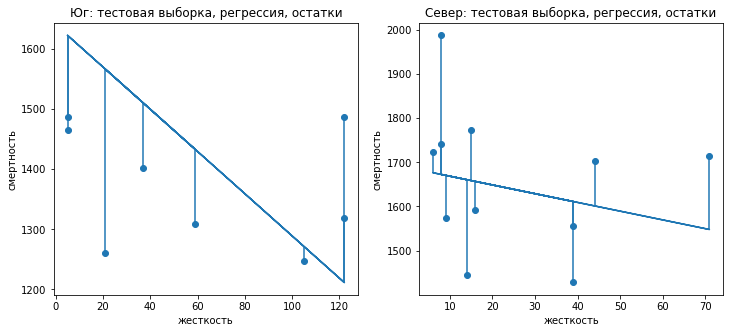

In [46]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(X_s_test, y_s_pred);
ax[0].scatter(X_s_test, y_s_test);
ax[0].vlines(X_s_test, y_s_pred, y_s_test);
ax[0].set(title = 'Юг: тестовая выборка, регрессия, остатки', ylabel = 'смертность', xlabel = 'жесткость');
ax[1].plot(X_n_test, y_n_pred);
ax[1].scatter(X_n_test, y_n_test);
ax[1].vlines(X_n_test, y_n_pred, y_n_test);
ax[1].set(title = 'Север: тестовая выборка, регрессия, остатки', ylabel = 'смертность', xlabel = 'жесткость');

<a href="#0"><h4>Наверх</h4></a>

<p id="3.3">
<h4>Кросс-валидация</h4>

* Построим модель на 1000 случайных выборок. Посчитаем коэффициенты регрессии и коэффициент детерминации.
* На юге коэффициенты регресии на 1000 выборках в среднем получились слабее, чем на одной случайной: угловой -2 и константа 1520 против углового -3.5 и константы 1650. Коэф. детерминации средний и медианный около 0.2.
* На севере коэффициенты регресии на 1000 выборках близки к результатам одной случайной. Коэф. детерминации средний -0.15, медианный тоже отрицательный, но практически 0.

In [47]:
reg_dict_s = {'a':[],'b':[],'R':[]}
reg_dict_n = {'a':[],'b':[],'R':[]}
for i in range(1000):
    X_s_train_2, X_s_test_2, y_s_train_2, y_s_test_2 = train_test_split(X_s, y_s, test_size = 0.30)
    model_s_2 = LinearRegression()
    model_s_2.fit(X_s_train_2, y_s_train_2)
    reg_dict_s['a'].append(model_s_2.coef_[0])
    reg_dict_s['b'].append(model_s_2.intercept_)
    y_s_pred_2 = model_s_2.predict(X_s_test_2)
    reg_dict_s['R'].append(model_s_2.score(X_s_test_2, y_s_test_2))
    
    X_n_train_2, X_n_test_2, y_n_train_2, y_n_test_2 = train_test_split(X_n, y_n, test_size = 0.30)
    model_n_2 = LinearRegression()
    model_n_2.fit(X_n_train_2, y_n_train_2)
    reg_dict_n['a'].append(model_n_2.coef_[0])
    reg_dict_n['b'].append(model_n_2.intercept_)
    y_n_pred_2 = model_n_2.predict(X_n_test_2)
    reg_dict_n['R'].append(model_n_2.score(X_n_test_2, y_n_test_2))

print('Юг')
print('угловой коэффициент')
print(np.mean(np.array(reg_dict_s['a'])),
      np.median(np.array(reg_dict_s['a'])),
      np.min(np.array(reg_dict_s['a'])),
      np.max(np.array(reg_dict_s['a'])))
print('свободный коэффициент')
print(np.mean(np.array(reg_dict_s['b'])),
      np.median(np.array(reg_dict_s['b'])),
      np.min(np.array(reg_dict_s['b'])),
      np.max(np.array(reg_dict_s['b'])))
print('коэф. детерминации')
print(np.mean(np.array(reg_dict_s['R'])),
      np.median(np.array(reg_dict_s['R'])),
      np.min(np.array(reg_dict_s['R'])),
      np.max(np.array(reg_dict_s['R'])))
print()
print('Север')
print('угловой коэффициент')
print(np.mean(np.array(reg_dict_n['a'])),
      np.median(np.array(reg_dict_n['a'])),
      np.min(np.array(reg_dict_n['a'])),
      np.max(np.array(reg_dict_n['a'])))
print('свободный коэффициент')
print(np.mean(np.array(reg_dict_n['b'])),
      np.median(np.array(reg_dict_n['b'])),
      np.min(np.array(reg_dict_n['b'])),
      np.max(np.array(reg_dict_n['b'])))
print('коэф. детерминации')
print(np.mean(np.array(reg_dict_n['R'])),
      np.median(np.array(reg_dict_n['R'])),
      np.min(np.array(reg_dict_n['R'])),
      np.max(np.array(reg_dict_n['R'])))

Юг
угловой коэффициент
-2.0804248101472993 -2.078161790011193 -3.445874063479983 -0.7850109047650516
свободный коэффициент
1522.21664967435 1521.9924533770163 1405.2230474545079 1644.9003057221207
коэф. детерминации
0.041195790824476844 0.20480444537586123 -3.9587577534100085 0.7966304594590113

Север
угловой коэффициент
-1.9187227319893938 -1.910968878663919 -3.885350415155056 -0.12811418082467324
свободный коэффициент
1691.873180734969 1692.2459653660208 1615.4779416733568 1758.3592277317662
коэф. детерминации
-0.13993997093692037 0.009363878275554405 -4.670093752795147 0.39947637541945746


<a href="#0"><h4>Наверх</h4></a>

<p id="3.4">
<h4>Вывод</h4><br>
* Я бы сказала, что средняя, близкая к слабой корреляция между смертностью и жесткостью есть в южных городах, в северных она слабая.<br>
* И на севере и на юге, и по одной случайной разбивке на обучающую и тестовую выборки и по 1000 разбивкам, получаются модели, по которым в среднем жесткость воды практически не объясняет вариацию смертности.

<p id="4">
<h3>Дополнительно (двухфакторная)</h3>
<p id="4.1">
<h4>Регрессия</h4>

Чтобы посмотреть взаимосвязь между жесткостью и смертностью на всей выборке, но при этому учитывать локацию города, добавим dummy переменную, отражающую место нахождение города - север или юг.

In [48]:
water['loc_ind'] = water.apply(lambda x: 1 if x.location == 'North' else 0, axis = 1)
water.head()

,location,town,mortality,hardness,loc_ind
1,South,Bath,1247,105,0
2,North,Birkenhead,1668,17,1
3,South,Birmingham,1466,5,0
4,North,Blackburn,1800,14,1
5,North,Blackpool,1609,18,1


In [49]:
X_3 = water[['hardness','loc_ind']]
y = water['mortality']

In [50]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y, test_size = 0.30, random_state = 42)

* Теперь два фактора, жесткость воды и север/юг.
* При сравнении двух городов с одинаковой жесткостью воды, смертность в северном городе ожидается (в среднем) на 169 больше, чем в южном.
* При сравнении двух северных или двух южных городов, в городе с жесткостью большей на 1 ед. смертность ожидается (в среднем) на 2.1 меньше.
* Коэф. детерминации стал выше 0.67.

In [51]:
model_3 = LinearRegression()
model_3.fit(X_train_3, y_train_3)
print(f'y = {model_3.coef_[0]:.2f} Hard + {model_3.coef_[1]:.2f} Loc + {model_3.intercept_:.2f}')
y_pred_3 = model_3.predict(X_test_3)
print(model_3.score(X_test_3, y_test_3))

y = -2.13 Hard + 169.23 Loc + 1530.17
0.6744447795073282


Гистограмма остатков разве что отдаленно напоминает нормальное распределение.

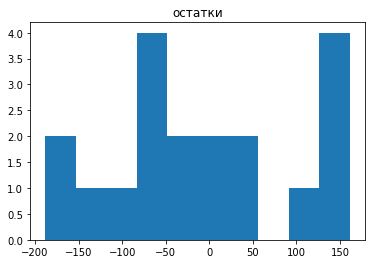

In [52]:
plt.hist(y_test_3 - y_pred_3);
plt.title('остатки');

На QQ plot точки в целом двигаются вдоль прямой. Будем считать, что серьезного отклонения остатков от нормального распределения нет.

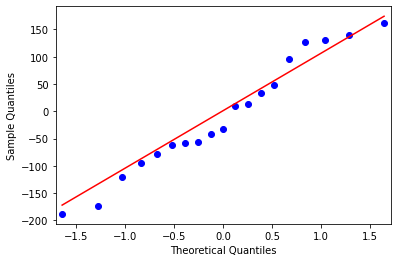

In [53]:
statsmodels.graphics.gofplots.qqplot(y_test_3 - y_pred_3, line = 'q');

Остатки достаточно хаотичны, в чередовании знаков закономерности не наблюдается:

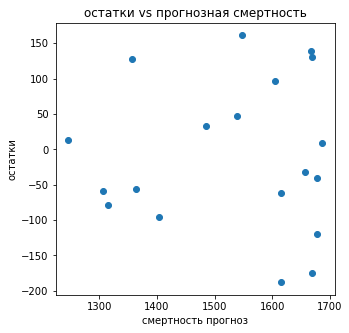

In [54]:
plt.figure(figsize = (5, 5)) 
plt.scatter(y_pred_3, y_test_3 - y_pred_3);
plt.title('остатки vs прогнозная смертность');
plt.xlabel('смертность прогноз');
plt.ylabel('остатки');

<a href="#0"><h4>Наверх</h4></a>

<p id="4.2">
<h4>Кросс-валидация</h4>

* На 1000 выборках средние и медианные коэффициенты достаточно близки к результатам одной случайной выборки. Коэф детерминации поменьше, около 0.5 по сравнению с 0.67.
* По сравнению с однофакторной моделью коэффициент фактора жесткости стал слабее,  вероятно взаимосвязь со смертностью на себя частично оттянула переменная север/юг.
* То есть какой-то признак связан со смертностью и с расположением на севере или юге. А так как жесткость воды при этом на севере ниже, то на общей выборке могло выглядеть так, как будто это из-за связи жесткости и смертности.
* Качество модели по коэф. детерминации увеличилось с 0.35 для однофакторной до 0.5 для двухфакторной.

In [55]:
reg_dict_3 = {'int':[],'Hard':[],'Loc':[],'R':[]}
for i in range(1000):
    X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y, test_size=0.30)
    model_3 = LinearRegression()
    model_3.fit(X_train_3, y_train_3)
    reg_dict_3['Hard'].append(model_3.coef_[0])
    reg_dict_3['Loc'].append(model_3.coef_[1])
    reg_dict_3['int'].append(model_3.intercept_)
    y_pred_3 = model_3.predict(X_test_3)
    reg_dict_3['R'].append(model_3.score(X_test_3, y_test_3))

print('коэффициент жесткости')
print(np.mean(np.array(reg_dict_3['Hard'])), 
        np.median(np.array(reg_dict_3['Hard'])), 
        np.min(np.array(reg_dict_3['Hard'])), 
        np.max(np.array(reg_dict_3['Hard'])))
print('коэффициент локации')
print(np.mean(np.array(reg_dict_3['Loc'])), 
      np.median(np.array(reg_dict_3['Loc'])),
      np.min(np.array(reg_dict_3['Loc'])), 
      np.max(np.array(reg_dict_3['Loc'])))
print('свободный коэффициент')
print(np.mean(np.array(reg_dict_3['int'])), 
      np.median(np.array(reg_dict_3['int'])),
      np.min(np.array(reg_dict_3['int'])), 
      np.max(np.array(reg_dict_3['int'])))
print('коэф. детерминации')
print(np.mean(np.array(reg_dict_3['R'])),
      np.median(np.array(reg_dict_3['R'])),
      np.min(np.array(reg_dict_3['R'])),
      np.max(np.array(reg_dict_3['R'])))

коэффициент жесткости
-2.0352754965705375 -2.0444469043246114 -3.1489903911813046 -0.8373874269147957
коэффициент локации
175.11355690822052 175.56936815781546 92.50665837890065 287.25412362376863
свободный коэффициент
1519.0265990521968 1518.791484783691 1388.4561016450973 1616.701911926559
коэф. детерминации
0.5036390599890546 0.5300759528161415 -0.31023703039755435 0.8043518618808743


<a href="#0"><h4>Наверх</h4></a>

<p id="4.3">
<h4>Вывод:</h4><br>
* Однофакторная модель: при сравнении двух городов, в городе с жесткостью воды на единицу выше, ожидается (в среднем) смертность на 3,1 (на 100тыс) ниже; жесткость объясняет 37% процентов вариации смертности (медианное значение коэф. детерминации)<br>
* Однофакторная модель (юг): при сравнении двух южных городов, в городе с жесткостью воды на единицу выше, ожидается (в среднем) смертность на 2 (на 100тыс) ниже (медианное значение); жесткость объясняет 20% процентов вариации смертности (медианное значение коэф. детерминации)<br>
* Однофакторная модель (север): при сравнении двух северных городов, в городе с жесткостью воды на единицу выше, ожидается (в среднем) смертность на 2 (на 100тыс) ниже (медианное значение); жесткость не объясняет вариацию смертности<br>
* Двухфакторная модель: при сравнении городов одной локации, в городе с жесткостью воды на единицу выше, ожидается (в среднем) смертность на 2 (на 100тыс) ниже; при сравнении северного и южного городов с одинаковой жесткостью, в северном смертность ожидается на 169 выше; жесткость и локация объясняют 52% процента вариации смертности (медианное значение коэф. детерминации)<br>
* Среди описанных выше моделей двухфакторная кажется более корректной, так учитывает и жесткость и локацию города. Смертность больше связана с локацией города, чем с жесткостью. Вероятно, есть какой-то скрытый фактор, который ассоциируется с повышенной смертностью на севере.

<a href="#0"><h4>Наверх</h4></a>